In [1]:
import os  # Manejo de archivos y rutas
import numpy as np  # Operaciones matemáticas y matrices
from scipy.io import wavfile  # Lectura y escritura de archivos WAV
import IPython  # Para reproducir audio en JupyterLab
import matplotlib.pyplot as plt  # Generación de gráficos
from scipy.fft import fft  # Transformada rápida de Fourier

In [2]:
# Especificar directorios de entrada y salida
cwd = os.getcwd()
audio_input_path = os.path.join(cwd, 'audio', 'examples')  # Ruta de la carpeta de audios de entrada
audio_output_path = os.path.join(cwd, 'audio', '_output')  # Ruta de la carpeta de audios de salida
print(f'Directorio con los audios de entrada: {audio_input_path}')
print(f'Directorio donde guardaremos los audios generados: {audio_output_path}\n')

Directorio con los audios de entrada: /home/felip/git/audio-/audio/examples
Directorio donde guardaremos los audios generados: /home/felip/git/audio-/audio/_output



In [3]:
# Cargar el archivo de audio
filename = os.path.join(audio_input_path, 'breaking_bad.wav')  # Nombre del archivo de audio a procesar
sample_rate, audio_data = wavfile.read(filename)  # Leer el archivo de audio WAV
print(f'Frecuencia de muestreo (sample rate): {sample_rate} Hz')

Frecuencia de muestreo (sample rate): 44100 Hz


In [4]:
# Convertir a mono tomando el promedio de los canales estéreo
new_data_mono = audio_data.mean(axis=1).astype(np.int16)

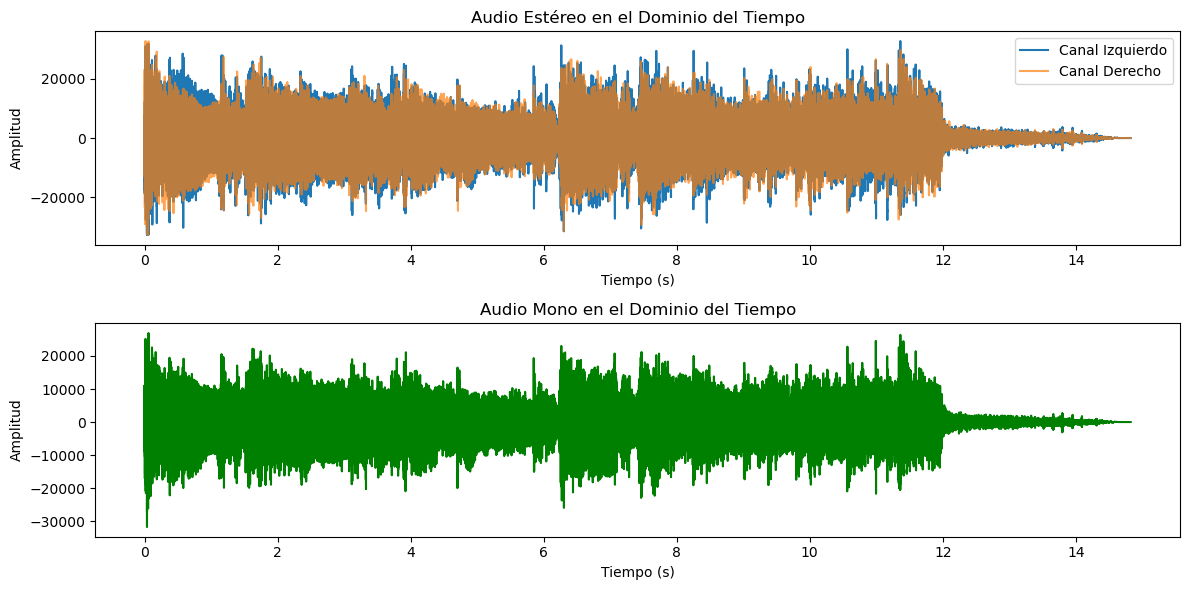

In [5]:
# Mostrar la gráfica en el dominio del tiempo
plt.figure(figsize=(12, 6))  # Configurar el tamaño del gráfico
time = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))  # Crear un eje de tiempo

plt.subplot(2, 1, 1)
plt.plot(time, audio_data[:, 0], label='Canal Izquierdo')  # Graficar canal izquierdo
plt.plot(time, audio_data[:, 1], label='Canal Derecho', alpha=0.7)  # Graficar canal derecho con menor opacidad
plt.title('Audio Estéreo en el Dominio del Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, new_data_mono, color='g')  # Graficar el audio en mono
plt.title('Audio Mono en el Dominio del Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

In [6]:
# Explicación de conceptos básicos de audio digital
explicacion = """
Frecuencia de muestreo: Número de muestras por segundo en un audio digital.
Aliasing: Distorsión causada por una baja frecuencia de muestreo.
Profundidad de bits: Cantidad de bits usados para representar cada muestra.
Ancho de banda: Rango de frecuencias que puede reproducir el audio.
Tasa de bits: Cantidad de datos procesados por segundo en un archivo de audio.
"""
print(explicacion)


Frecuencia de muestreo: Número de muestras por segundo en un audio digital.
Aliasing: Distorsión causada por una baja frecuencia de muestreo.
Profundidad de bits: Cantidad de bits usados para representar cada muestra.
Ancho de banda: Rango de frecuencias que puede reproducir el audio.
Tasa de bits: Cantidad de datos procesados por segundo en un archivo de audio.



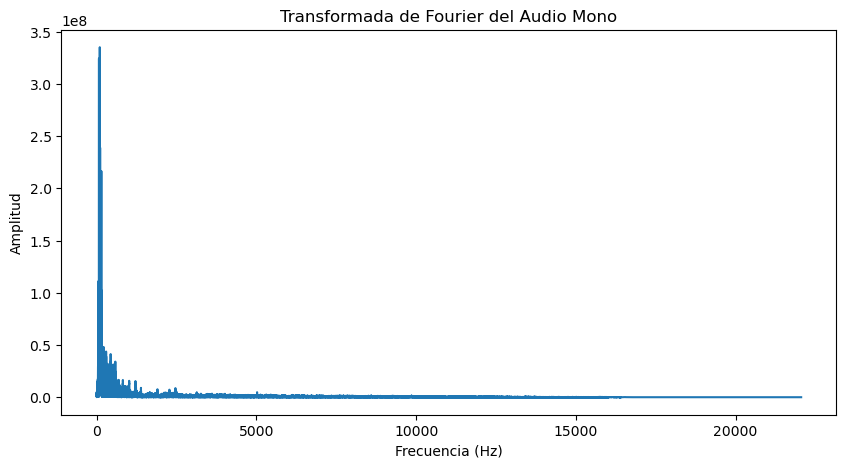

In [7]:
# Transformada rápida de Fourier (FFT) usando el método del profesor
n = len(new_data_mono)  # Longitud de la señal
Fs = sample_rate  # Frecuencia de muestreo

# Calcular la FFT
ch_Fourier = np.fft.fft(new_data_mono)
abs_ch_Fourier = np.abs(ch_Fourier[:n//2])  # Tomamos solo la mitad del espectro (Nyquist)

# Graficar la FFT
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, Fs/2, n//2), abs_ch_Fourier)
plt.title('Transformada de Fourier del Audio Mono')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.show()


Epsilon seleccionado: 0.041
Valor de corte para la energía del espectro: 248612565791.91467
Máscara de frecuencias a eliminar: [False False False ...  True  True  True]
Frecuencia de corte f0 (Hz): 11090


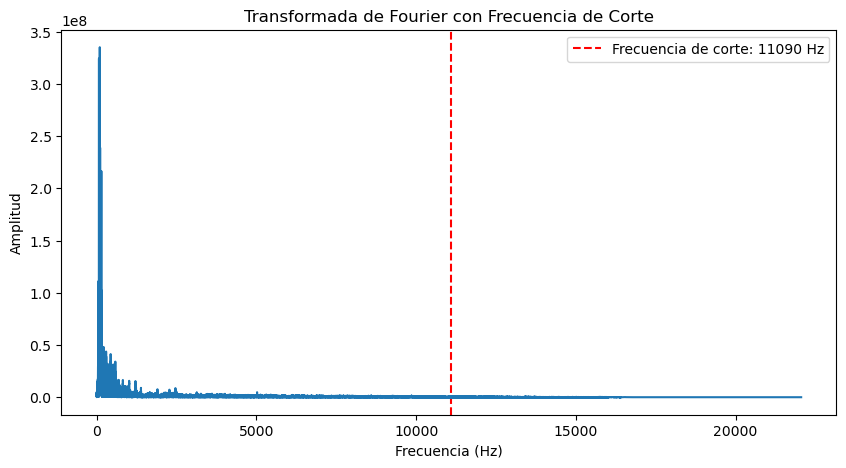

In [8]:
# Definimos diferentes valores de epsilon (parte de la energía del espectro que NO conservamos)
eps = [1e-5, .02, .041, .063, .086, .101, .123]

# Elegimos el primer valor de epsilon (puedes probar otros para ver su efecto en la gráfica)
eps = eps[2]  # Puedes cambiar el índice para probar distintos valores
print(f'Epsilon seleccionado: {eps}')

# Calculamos el valor de corte para esta energía
thr_spec_energy = (1 - eps) * np.sum(abs_ch_Fourier)
print(f'Valor de corte para la energía del espectro: {thr_spec_energy}')

# Integral acumulativa de la energía del espectro
spec_energy = np.cumsum(abs_ch_Fourier)

# Máscara booleana para determinar qué frecuencias eliminar
frequencies_to_remove = thr_spec_energy < spec_energy  
print(f'Máscara de frecuencias a eliminar: {frequencies_to_remove}')

# Cálculo de la frecuencia de corte f0
f0 = (len(frequencies_to_remove) - np.sum(frequencies_to_remove)) * (Fs / 2) / (n // 2)
print(f'Frecuencia de corte f0 (Hz): {int(f0)}')

# Graficamos la FFT con la frecuencia de corte marcada en rojo
plt.figure(figsize=(10, 5))
plt.axvline(f0, color='r', linestyle='--', label=f'Frecuencia de corte: {int(f0)} Hz')
plt.plot(np.linspace(0, Fs/2, n//2), abs_ch_Fourier)
plt.title('Transformada de Fourier con Frecuencia de Corte')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()


Factor de downsampling: 3
Tamaño de new_data: 217916
Fs: 44100, f0: 11090.366012592009, Factor de downsampling: 3
Nueva frecuencia de muestreo: 14700


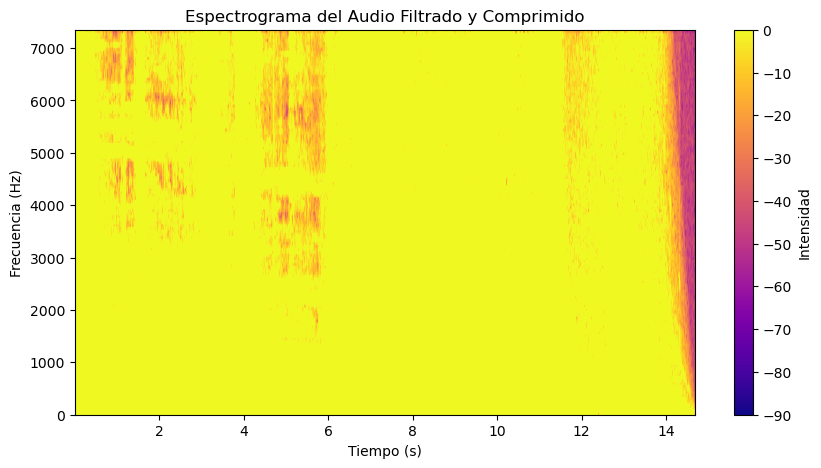

In [9]:
D = int(Fs / f0)  # Factor de downsampling
print(f'Factor de downsampling: {D}')

# Aplicamos el downsampling tomando cada D-ésimo valor del audio original
new_data = new_data_mono[::D]

# Nueva frecuencia de muestreo
new_sample_rate = int(Fs / D)

# Verificaciones para asegurar que los datos son válidos
print(f"Tamaño de new_data: {len(new_data)}")
print(f"Fs: {Fs}, f0: {f0}, Factor de downsampling: {D}")
print(f"Nueva frecuencia de muestreo: {new_sample_rate}")

# Asegurar que new_data no está vacío
if len(new_data) == 0:
    raise ValueError("Error: Los datos comprimidos están vacíos después del downsampling.")

# Guardamos el archivo comprimido
wav_compressed_file = "breaking_bad_compressed.wav"
wavfile.write(wav_compressed_file, rate=new_sample_rate, data=new_data)

# Cargamos el nuevo archivo para verificación
new_sample_rate, new_audio_data = wavfile.read(wav_compressed_file)

# Eliminar ceros si existen en la señal para evitar problemas con log10
new_audio_data = new_audio_data[new_audio_data != 0]

# Verificar nuevamente después de limpiar los ceros
if len(new_audio_data) == 0:
    raise ValueError("Error: Los datos están vacíos después de eliminar los ceros.")

# Visualizamos el espectrograma del audio filtrado y comprimido
plt.figure(figsize=(10, 5))
plt.specgram(new_audio_data, Fs=new_sample_rate, cmap='plasma', vmin=-90, vmax=0)
plt.title('Espectrograma del Audio Filtrado y Comprimido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label='Intensidad')
plt.show()

In [10]:
# Guardar el archivo comprimido
compressed_filename = os.path.join(audio_output_path, 'breaking_bad_compressed.wav')
wavfile.write(compressed_filename, rate=new_sample_rate, data=new_data)

Factor de downsampling: 2
Tamaño de new_data_compressed: 326874


/home/felip/anaconda3/envs/entorno/lib/python3.9/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


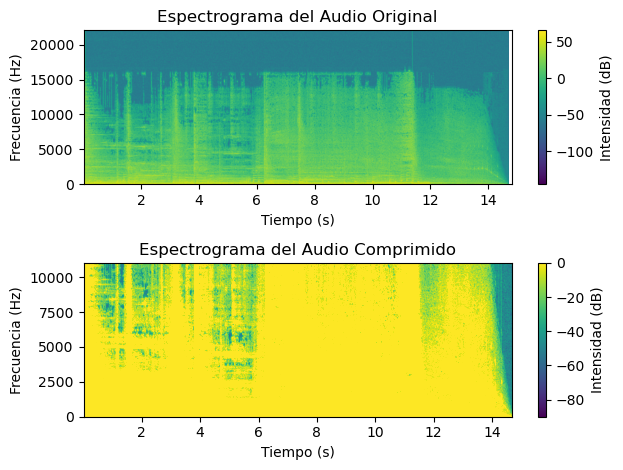

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os

# Reducimos la frecuencia de muestreo a la mitad (downsampling)
new_sample_rate = int(sample_rate / 2)

# Calcular el factor de downsampling
D = int(sample_rate / new_sample_rate)  # Factor de downsampling
print(f'Factor de downsampling: {D}')

# Aplicar el downsampling tomando cada D-ésimo valor
new_data_compressed = new_data_mono[::D]  # Tomamos cada D-ésimo valor del audio

# Verificaciones adicionales
print(f"Tamaño de new_data_compressed: {len(new_data_compressed)}")
if len(new_data_compressed) == 0:
    raise ValueError("Error: Los datos comprimidos están vacíos después del downsampling.")

# Espectrograma del audio original
plt.subplot(2, 1, 1)
Pxx, freqs, bins, im = plt.specgram(audio_data[:, 0], NFFT=1024, Fs=sample_rate, noverlap=512)
plt.title('Espectrograma del Audio Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label='Intensidad (dB)')

# Eliminar ceros si existen en la señal para evitar problemas con log10
new_data_compressed = new_data_compressed[new_data_compressed != 0]

# Verificar nuevamente después de limpiar los ceros
if len(new_data_compressed) == 0:
    raise ValueError("Error: Los datos están vacíos después de eliminar los ceros.")

# Espectrograma del audio comprimido
plt.subplot(2, 1, 2)
Pxx, freqs, bins, im = plt.specgram(new_data_compressed, NFFT=1024, Fs=new_sample_rate, noverlap=512, vmin=-90, vmax=0)
plt.title('Espectrograma del Audio Comprimido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label='Intensidad (dB)')

plt.tight_layout()
plt.show()

# Guardar el archivo comprimido con la nueva frecuencia de muestreo
compressed_filename = os.path.join(audio_output_path, 'breaking_bad_compressed.wav')
wavfile.write(compressed_filename, rate=new_sample_rate, data=new_data_compressed)


In [12]:
#El espectrograma del audio original muestra un rango de frecuencias de hasta 20 kHz, 
#mientras que el audio comprimido se limita a 10 kHz, perdiendo las frecuencias altas y, con ellas, 
#detalles importantes del sonido. Además, el audio comprimido presenta saturación en la intensidad (zonas amarillas) 
#debido a la corrección aplicada para evitar errores matemáticos, lo que afecta la precisión en la representación de la señal.

In [13]:


# Obtener el tamaño de los archivos en bytes
original_file_size = os.path.getsize(filename)  # Tamaño del archivo original
compressed_file_size = os.path.getsize(compressed_filename)  # Tamaño del archivo comprimido

# Convertir de bytes a MB
original_file_size_MB = original_file_size / (1024 * 1024)
compressed_file_size_MB = compressed_file_size / (1024 * 1024)

# Imprimir los tamaños en MB
print(f"Tamaño del archivo original: {original_file_size_MB:.2f} MB")
print(f"Tamaño del archivo comprimido: {compressed_file_size_MB:.2f} MB")


Tamaño del archivo original: 2.49 MB
Tamaño del archivo comprimido: 0.62 MB


In [14]:
import IPython.display as ipd

# Reproducir el audio original
print("Reproduciendo el audio original:")
ipd.display(ipd.Audio(filename))

# Reproducir el audio comprimido
print("Reproduciendo el audio comprimido:")
ipd.display(ipd.Audio(compressed_filename))

Reproduciendo el audio original:


Reproduciendo el audio comprimido:
